
# <font size="+3" color="black"><b>P6 - Classifiez automatiquement des biens de consommation</b></font><br>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



---

---

<font size="+2" color="black"><b>**LOADING LIBRAIRIES**</b></font><br><a name="LOADING_LIBRARIES"></a>

---


In [2]:

# ----------------------
# Packages installation
# ----------------------
!pip install transformers
!pip install opencv-python
!pip install opencv-contrib-python
!pip install PIL
!pip install plot-keras-history
!pip install pathlib


# Builtin
import os
import shutil 
import glob
import pandas as pd
import numpy as np
import csv
import time
import datetime
from math import pi
import re
import tensorflow
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import metrics as kmetrics
from pathlib import Path

# Traitement image
import cv2
import PIL
from PIL import Image, ImageOps, ImageFilter

# Implementation VGG-16
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from sklearn import preprocessing
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from plot_keras_history import show_history, plot_history


# Data visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline
import seaborn as sns
from PIL import Image

# Data agumentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Réduction dimensions
from sklearn import manifold, decomposition
from sklearn.manifold import TSNE

# Clustering
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics.cluster import adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score


'''
# -------------------------------------------------------------
# Checking the version numbers of the installed packages
# -------------------------------------------------------------
'''
print('Librairies version : \n')

print('Pandas      : ' + pd.__version__)
print('NumPy       : ' + np.version.full_version)
print('Csv         : ' + csv.__version__ + '\n')

print('Matplotlib  : ' + mpl.__version__)
print('Seaborn     : ' + sns.__version__ + '\n')

now = datetime.datetime.now().isoformat()
print('Launched on : ' + now)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 113.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.

---
---

<font size="+1" color="black"><b>FUNCTIONS USED IN THIS NOTEBOOK</b></font><br><a name="USED_FUNCTIONS"></a>

---

In [3]:
# --------------------------------------------------------------------
# Analyse en composantes principales - Réduction de dimension
# --------------------------------------------------------------------

def reduire_dimension_acp(matrice, n_components=0):
    '''
    Analyse en composante principale
    Parameters
    ----------
    matrice : Variable à analyser, obligatoire
    n_components : nombre de composants pour la réduction de dimension
    exemple :  PC1/PC2 et PC3/PC4 ==> [(0, 1), (2, 3)], obligatoire
    affiche_graph : affiche les autres graphiques ; éboulis, distribution...
    Returns
    -------
    None.
    '''
    # Sélection des colonnes pour l'ACP
    cols_acp = matrice.columns.to_list()
    # Nombre de composantes
    if n_components == 0:
        n_comp = len(cols_acp)
    else:
        n_comp = n_components

    # Calcul des composantes principales
    pca = decomposition.PCA(n_components=n_comp)
    pca.fit(matrice)

    # quel est le pourcentage de variance préservé par chacune de
    # nos composantes?
    variances = pca.explained_variance_ratio_

    # quelle est la somme cumulée de chacune de ces variances?
    meilleur_dims = np.cumsum(variances)

    # on va trouver le moment où on atteint 90% ou 95% entre réduire au maxi
    # où garder au maxi

    # argmax pour > 90 %
    best90 = np.argmax(meilleur_dims > 0.9)

    # argmax pour > 95 %
    best = np.argmax(meilleur_dims > 0.95)

    display(f'Nombre de composantes expliquant 90% de la variance : {best90}')
    display(f'Nombre de composantes expliquant 95% de la variance : {best}')

In [4]:
cols = ["VAR1", "VAR2"]

In [5]:
# Dataframe de sauvegarde des résultats des métriques KMeans
df_metrics_kmeans = pd.DataFrame()

In [6]:
# --------------------------------------------------------------------
# -- CALCUL DES METRIQUES K-Means
# --------------------------------------------------------------------

def calcul_metrics_kmeans(data, dataframe_metrique, type_donnees,
                          random_seed, ninit, maxiter):
    '''
    Calcul des métriques de KMeans en fonction de différents paramètres.
    Parameters
    ----------
    data : données, obligatoire.
    dataframe_metrique : dataframe de sauvegarde des résultats, obligatoire.
    type_donnees : string intitulé des données, obligatoire.
    random_seed : nombre aléatoire pour la reproductibilité, obligatoire.
    ninit : nombre de clusters à initialiser, obligatoire.
    maxiter : type d'initialisation : 'k-means++' ou 'random'.
    Returns
    -------
    dataframe_metrique : résultat des métriques
    '''
    # Cette fonction permet de calculer le nombre de clusters le plus
    # optimal pour notre analyse : le coefficient de silhouette,
    # dispersion, indice de davies_bouldin
    silhouette = []
    dispersion = []
    davies_bouldin = []
    donnees = []
    temps = []

    result_ninit = []
    result_maxiter = []

    # Hyperparametre tuning

    ninit = ninit
    maxiter = maxiter

    # Recherche des hyperparamètres
    for var_ninit in ninit:

        for var_maxiter in maxiter:

            # Top début d'exécution
            time_start = time.time()

            # Initialisation de l'algorithme
            cls = KMeans(n_clusters=7,
                         n_init=var_ninit,
                         init='k-means++',
                         max_iter=var_maxiter,
                         random_state=random_seed)

            # Entraînement de l'algorithme
            cls.fit(data)

            # Prédictions
            preds = cls.predict(data)

            # Top fin d'exécution
            time_end = time.time()

            # Calcul du score de coefficient de silhouette
            silh = metrics.silhouette_score(data, preds)
            # Calcul la dispersion
            disp = cls.inertia_
            # Calcul de l'indice davies-bouldin
            db = metrics.davies_bouldin_score(data, preds)
            # Durée d'exécution
            time_execution = time_end - time_start

            silhouette.append(silh)
            dispersion.append(disp)
            davies_bouldin.append(db)
            donnees.append(type_donnees)
            temps.append(time_execution)

            result_ninit.append(var_ninit)
            result_maxiter.append(var_maxiter)

    dataframe_metrique = dataframe_metrique.append(pd.DataFrame({
        'Type_données': donnees,
        'n_init': result_ninit,
        'max_iter': result_maxiter,
        'coef_silh': silhouette,
        'dispersion': dispersion,
        'davies_bouldin': davies_bouldin,
        'Durée (s)': temps
    }), ignore_index=True)

    return dataframe_metrique

In [7]:
# --------------------------------------------------------------------
# SCATTERPLOT DE VISUALISATION DE TRANSFORMATION T-SNE en 2D
# --------------------------------------------------------------------
def affiche_tsne(results_list, liste_param, alpha=0.1):
    '''
    Affiche les résultats de la transformation Lt-SNE
    -----------
    @ Parameters
    * results_list : iste des résultats de la transformation t-SNE
    * liste_param : liste des valeurs de l'hyper paramètre perplexity testées

    -----------
    @ Returns
    * Scatterplots
    '''

    i = 0

    # Visualisation en 2D des différents résultats selon la perplexité
    plt.subplots(6, 2, figsize=[12, 28])

    for resultat_tsne in results_list:
        plt.subplot(6, 2, i + 1)
        tsne_results_i = results_list[i]
        sns.scatterplot(x=tsne_results_i[:, 0], y=tsne_results_i[:, 1],
                        alpha=alpha)
        plt.title('t-SNE avec perplexité=' + str(liste_param[i]))
        plt.grid(False)
        plt.plot()

        i += 1

    plt.show()

In [8]:
# Détermination clusters après PCA et calcul ARI entre
# vrai catégorie et n° de clusters

def ARI_fct(X_proj, init_method, Ninit, m_iter, df_donnees, df_analyse) :

    """
    ----------
    @Paramètres:
    * X_proj : datamatrix
    * df_donnees : df avec l'information des catégories reelles
    * df_analyse: nom du df pour enregistrer les résultats
    """

    # Dataframe pour clustering
    df_analyse = pd.DataFrame({"VAR1" : X_proj[:, 0],
                               "VAR2": X_proj[:, 1],
                               "CATEGORIE" : df_donnees.Categ_N0})

    num_labels=len(l_cat)
    # Instantiation du modèle k-means
    cls = KMeans(n_clusters=num_labels, init=init_method, n_init=Ninit,
                 random_state=seed, max_iter=m_iter)
    cls.fit(df_analyse[cols])
    # Ajout de l'assignation du cluster au dataframe
    df_analyse["Clusters"] = cls.labels_
    kmeans_labels = cls.labels_
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)

    return ARI, kmeans_labels, df_analyse

In [9]:
# ------------------------------------------------------------
# Scatterplot ACP selon les vraies catégories et les clusters
# ------------------------------------------------------------
def dimReduc_visu_fct(X_projected, y_cat_num, labels, ARI, methode):
    '''
    Affiche la projection scatterplot par catégories et clusters.
    -----------
    @Parameters
    * X_projected : Datamatrix après projection, obligatoire.
    * labels : la variable représentant les clusters.
    * methode : str, nom de la methode de reduction de dimensions
    --------
    @Returns
    Scatterplots
    '''
    fig = plt.figure(figsize=(15, 6))

    # Scatterplot des catégories
    ax = fig.add_subplot(121)
    scatter = ax.scatter(x=X_projected[:, 0], y=X_projected[:, 1],
                         c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0],
              labels=l_cat, loc="best", title="Categorie")
    plt.title(methode + 'Représentation par catégories réelles')

    # Scatterplot des clusters
    ax = fig.add_subplot(122)
    scatter = ax.scatter(x=X_projected[:, 0], y=X_projected[:, 1],
                         c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels),
              loc="best", title="Clusters")
    plt.title(methode + 'Représentation par clusters')

    plt.show()
    print("ARI : ", ARI)

---
---

<font size="+1" color="black"><b>PARAMETERS USED IN THIS NOTEBOOK</b></font><br><a name="USED_PARAMETERS"></a>

---

In [10]:
# Parameters used in this notebook
seed = 84

%pycodestyle_off


<font size="+3" color="black"><b>P6 - Classifiez automatiquement des biens de consommation</b></font><br><a name="context"></a>



Ce notebook fait partie u projet d'automamatisation de l'attibution de la catégorie d'un article sur le site ***place de marché***.


![logo](https://user.oc-static.com/upload/2019/02/24/15510259240381_Projet%20textimage%20logo.png)

L'objectif du projet est de<br>



---
---

**Ce notebook** inclut **le nettoyage et exploration des données**.<br>


---
---

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home"><font size="+3" color="#903b3f"><b>Table de matières</b></font><br><a id="objective"></a></h3>

* [Librairies loading](#LOADING_LIBRARIES)
* [Functions used in this notebook](#USED_FUNCTIONS)   
* [Context](#context)  
* [1. Dataset](#dataset)
    - [1.1. Création d'une colonne avec le nom de la vraie catégorie](#categorie_N0)
    
* [2. Classification supervisée](#classif_superv)
    - [2.1. Création du modèle de classification](#creation_modele)
    - [2.2. Approche préparation initiale des images](#prep_init)
    - [2.3. Approche ImageDatagenerator avec data augmentation](#imgDataGen)
    - [2.4. Approche nouvelle par Dataset sans data augmentation](#new_approach)
        - [2.4.1. Modification structure dossier images](#modif_structure_dossier)
        - [2.4.2. Application approche](#applic_approche)
    - [2.5. Approche nouvelle par Dataset avec data augmentation intégrée au modèle](#new_approach_dataAug)
* [3. Comparaison des performances](#comparaison_perf)




---
---

# <font size="+3" color="#5c2835"><b>1. Dataset</b></font><br><a name="dataset"></a>


In [11]:
# Define the folder containing the files with the project data
P6_source = "/content/drive/MyDrive/Projet6_NLP/P6_travail/p6_source/"

os.chdir(P6_source)

# .csv files number and name
allFilesCsv = glob.glob('*.csv')

# -------------
# File upload:
# -------------
fn = P6_source + "flipkart_com-ecommerce_sample_1050.csv"
df_text = pd.read_csv(fn, low_memory=False, encoding='utf-8')

In [12]:
# Dossier contenant les images disponibles
path_images = "/content/drive/MyDrive/Projet6_NLP/P6_travail/p6_source/Images/"

# Taille redimensionement
dim = (224, 224)

## <font size="+2" color="#903b3f"><b>1.1. Création d'une colonne avec le nom de la vraie catégorie</b></font><br><a name="categorie_N0"></a>

In [13]:
# Regex expresion pour supprimer '["' et '"]'
def supprimer_crochets(text):
    croch_ini = re.sub('(\[")', '', text)
    return re.sub('(\"])', '', croch_ini)


# Regex expresion pour supprimer '["' et '"]'

df_text["product_category_tree"] = df_text["product_category_tree"]\
                                    .apply(supprimer_crochets)

In [14]:
# Spliter la chaine de caracteres à "" >> " et créer une colonne
# pour chaque niveau de l'arbre de catégories
df_catg = df_text["product_category_tree"].str.split(" >> ", expand=True)

df_catg = df_catg.rename(columns={0: "Categ_N0", 1: "Categ_N1", 2: "Categ_N2",
                                  3: "Categ_N3", 4: "Categ_N4", 5: "Categ_N5",
                                  6: "Categ_N6"})
df_catg.sample(6)

,Categ_N0,Categ_N1,Categ_N2,Categ_N3,Categ_N4,Categ_N5,Categ_N6
96,Home Decor & Festive Needs,Table Decor & Handicrafts,Showpieces,Human Figurines,My Angel Human Figurines,None,None
658,Home Decor & Festive Needs,Wall Decor & Clocks,Wall Decals & Stickers,Creative Width Decor Wall Decals & Stickers,None,None,None
1013,Beauty and Personal Care,Fragrances,Deodorants,Sprays,LAWMAN PG3 Sprays,"LAWMAN PG3 Striker,, Winger , Contender Deodor...",None
163,Kitchen & Dining,Coffee Mugs,Printland Coffee Mugs,None,None,None,None
389,Beauty and Personal Care,Fragrances,Deodorants,Combos,Playboy Combos,None,None
134,Kitchen & Dining,Coffee Mugs,Rajesh Digital Coffee Mugs,None,None,None,None


In [15]:
# Liste des vraies catégories
categories_liste = list(set(df_catg["Categ_N0"]))

In [16]:
# Réunir ce tableau avec les colonnes texte d'intêret
df_text = df_text.reset_index()
df_catg = df_catg.reset_index()

df_text_analysis = df_text.merge(df_catg, on="index", how="left")

df_text_analysis = df_text_analysis.drop(columns="index")
df_text = df_text.drop(columns="index")
df_catg = df_catg.drop(columns="index")

In [17]:
# Créer un tableau avec les données necessaires pour l'étude
df_classif_superv = df_text_analysis[["image", "Categ_N0"]]

# Ajout variable image_loc
# ex : data/Images/02127f52e96fb72c66bf081d25104ef8.jpg
path = path_images
df_classif_superv["image_loc"] = [path + row for row in
                                  df_classif_superv["image"]]

# Encodage des catégories
le = preprocessing.LabelEncoder()
le.fit(df_classif_superv["Categ_N0"])
df_classif_superv["Categ"] = le.transform(df_classif_superv["Categ_N0"])

df_classif_superv.head()

<ipython-input-17-cae054e41667>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_classif_superv["image_loc"] = [path + row for row in
<ipython-input-17-cae054e41667>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_classif_superv["Categ"] = le.transform(df_classif_superv["Categ_N0"])


,image,Categ_N0,image_loc,Categ
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,/content/drive/MyDrive/Projet6_NLP/P6_travail/...,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,/content/drive/MyDrive/Projet6_NLP/P6_travail/...,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,/content/drive/MyDrive/Projet6_NLP/P6_travail/...,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,/content/drive/MyDrive/Projet6_NLP/P6_travail/...,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,/content/drive/MyDrive/Projet6_NLP/P6_travail/...,4


In [18]:
# Création d'un set d'entraînement et un set de test

X = df_classif_superv[["image_loc"]]
y = df_classif_superv["Categ"]

images, img_test, categories, categ_test = train_test_split(X, y,
                                                            stratify=y,
                                                            test_size=0.25,
                                                            random_state=seed)

In [19]:
# Recalculer les index pour avoir des listes de valeurs continus

images = images.reset_index()
# Création d'un df qui servira de reference pour la data agumentation
df_reference = df_classif_superv.loc[df_classif_superv.index
                                     .isin(list(images.index.values))]

print("images train", images.shape)
print()

img_test = img_test.reset_index()
# Création d'un df qui servira de test pour la data agumentation
df_test = df_classif_superv.loc[df_classif_superv.index
                                .isin(list(img_test.index.values))]
print("images test", img_test.shape)

images train (787, 2)

images test (263, 2)


<Axes: >

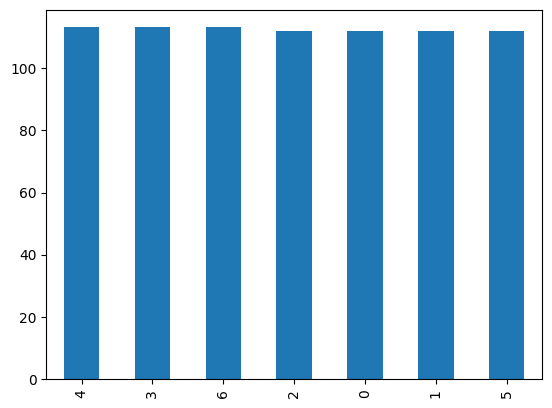

In [20]:
# Visualisation de la representation des catégories dans le set qui servira
# à l'entraînement et validation
categories.value_counts().plot(kind="bar")

<Axes: >

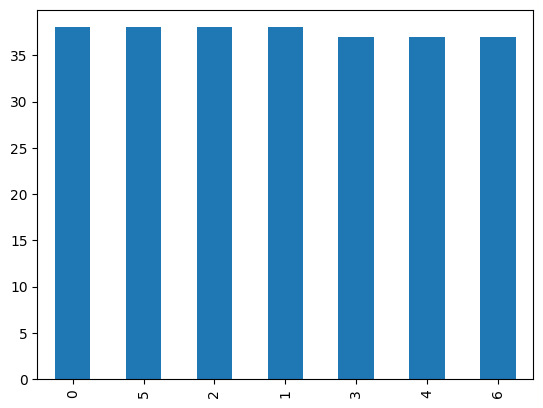

In [21]:
# Visualisation de la representation des catégories dans le set qui servira
# au test
categ_test.value_counts().plot(kind="bar")

# <font size="+3" color="#5c2835"><b>2. Classification supervisée</b></font><br><a name="classif_superv"></a>

3 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
* Une approche par DataSet, avec data augmentation intégrée au modèle : layer en début de modèle

In [22]:
# Liste pour enregistrer les informations nécessaires
#  à la comparaison des performances
approach = []
loss_vali_opt = []
accuracy_vali_opt = []
loss_test_opt = []
accuracy_test_opt = []

## <font size="+2" color="#903b3f"><b>2.1. Création du modèle de classification</b></font><br><a name="creation_modele"></a>

In [23]:
def create_model_VGG16_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet",
                   input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop',
                  metrics=["accuracy"])

    print(model.summary())
    
    return model

## <font size="+2" color="#903b3f"><b>2.2. Approche préparation initiale des images</b></font><br><a name="prep_init"></a>

In [24]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image_loc'])) :
        img = (load_img(
            data['image_loc'][image_num],
            target_size=dim))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np

images_np = image_prep_fct(images)
print(images_np.shape)
images_np_test = image_prep_fct(img_test)
print(images_np_test.shape)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(787, 224, 224, 3)
(263, 224, 224, 3)


In [25]:
X_model = images_np
y_model = to_categorical(categories)

img_test = images_np_test
categ_test = to_categorical(categ_test)

y_model

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [26]:
img_train, img_val, categ_train, categ_val = train_test_split(X_model, y_model,
                                                              stratify=y_model,
                                                              test_size=0.25,
                                                              random_state=seed)
img_train.shape

(590, 224, 224, 3)

In [27]:
# Création du modèle
with tensorflow.device('/gpu:0'):
    model1 = create_model_VGG16_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss',
                             verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [28]:
# Entraîner sur les données d'entraînement (img_train, categ_train)
with tensorflow.device('/gpu:0'):
    history1 = model1.fit(img_train, categ_train, epochs=50, batch_size=64,
                          callbacks=callbacks_list, validation_data=(img_val,
                                                                     categ_val),
                          verbose=1)

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 6.2035 - accuracy: 0.4271
Epoch 1: val_loss improved from inf to 1.98649, saving model to ./model1_best_weights.h5
10/10 [==============================] - 25s 958ms/step - loss: 6.2035 - accuracy: 0.4271 - val_loss: 1.9865 - val_accuracy: 0.7208
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 2.2138 - accuracy: 0.6559
Epoch 2: val_loss improved from 1.98649 to 1.69551, saving model to ./model1_best_weights.h5
10/10 [==============================] - 3s 324ms/step - loss: 2.2138 - accuracy: 0.6559 - val_loss: 1.6955 - val_accuracy: 0.7766
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 1.2726 - accuracy: 0.7271
Epoch 3: val_loss improved from 1.69551 to 1.42627, saving model to ./model1_best_weights.h5
10/10 [==============================] - 3s 322ms/step - loss: 1.2726 - accuracy: 0.7271 - val_loss: 1.4263 - val_accuracy: 0.7817
Epoch 4/50
10/10 [==============================]

In [29]:
# Score du dernier epoch
loss, accuracy = model1.evaluate(img_train, categ_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()

loss, accuracy = model1.evaluate(img_val, categ_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

19/19 [==============================] - 6s 115ms/step - loss: 0.0723 - accuracy: 0.9847
Training Accuracy: 0.9847

7/7 [==============================] - 1s 106ms/step - loss: 1.5054 - accuracy: 0.7563
Validation Accuracy:  0.7563


In [30]:
# Score de l'epoch optimal
model1.load_weights(model1_save_path1)
loss_vali_model1, accuracy_vali_model1 = model1.evaluate(img_val, categ_val,
                                                         verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_vali_model1))

loss_test_model1, accuracy_test_model1 = model1.evaluate(img_test, categ_test,
                                                         verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_model1))

Validation Accuracy :  0.7817
Test Accuracy       :  0.8289


In [31]:
# Information à garder pour la comparaison des performances

approach.append("Prep_Init")
loss_vali_opt.append(loss_vali_model1)
accuracy_vali_opt.append(accuracy_vali_model1)
loss_test_opt.append(loss_test_model1)
accuracy_test_opt.append(accuracy_test_model1)

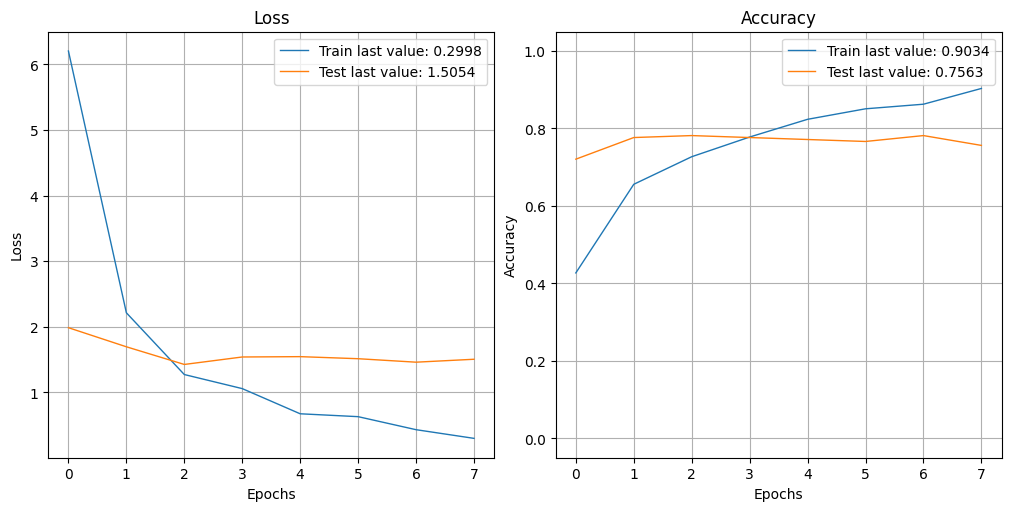

In [32]:
show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [33]:
categ_val_num = np.argmax(categ_val, axis=1)
categ_val_pred = np.argmax(model1.predict(img_val), axis=1)

print(categ_val_num)
print()
print(categ_val_pred)

7/7 [==============================] - 1s 130ms/step
[3 0 3 4 2 4 5 2 5 6 2 2 3 1 4 0 0 5 2 3 3 1 1 0 6 5 1 4 4 0 3 0 3 6 2 0 6
 0 2 2 4 5 0 1 6 0 4 3 3 1 2 5 1 4 5 5 6 5 0 2 4 5 0 6 0 2 3 5 6 3 1 2 6 3
 6 1 0 4 3 5 2 3 4 2 5 2 0 5 5 6 1 4 2 4 5 1 4 2 3 0 0 4 2 6 6 2 3 6 6 5 6
 0 5 4 2 6 2 5 2 1 3 2 6 2 4 6 1 1 4 6 4 4 1 6 2 6 1 0 0 3 3 1 6 1 3 5 4 1
 5 4 5 3 6 2 0 5 4 3 6 3 6 0 0 1 1 0 6 5 0 2 0 1 1 4 3 4 4 6 5 3 4 1 0 0 3
 3 5 5 3 1 1 4 1 6 1 2 5]

[2 0 6 4 0 3 5 2 5 6 2 2 3 1 3 0 3 5 4 3 5 1 0 0 6 5 2 4 3 3 3 0 3 6 2 0 1
 4 2 2 0 5 0 1 6 4 4 3 3 1 2 5 1 3 5 5 6 5 0 2 0 0 0 6 0 2 2 5 6 3 5 6 6 3
 6 1 0 4 3 5 2 3 4 2 5 1 0 5 5 0 1 4 2 4 5 1 4 2 3 3 3 4 2 6 6 3 3 1 6 5 6
 0 5 0 2 6 2 5 2 1 1 2 6 2 4 6 2 1 4 6 4 0 1 6 2 6 1 0 0 3 3 1 6 1 3 5 4 5
 5 4 5 6 6 2 4 5 4 2 6 3 6 0 0 1 1 3 6 2 0 2 0 1 1 4 5 4 4 6 5 3 4 1 0 0 3
 3 3 5 3 2 1 4 1 6 5 2 1]


In [34]:
conf_mat = metrics.confusion_matrix(categ_val_num, categ_val_pred)
print(conf_mat)

[[20  0  0  5  3  0  0]
 [ 1 21  3  0  0  3  0]
 [ 1  1 23  1  1  0  1]
 [ 0  1  3 20  0  2  2]
 [ 4  0  0  4 20  0  0]
 [ 1  1  1  1  0 24  0]
 [ 1  2  0  0  0  0 26]]


In [35]:
def conf_mat_transform(y_true, y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [36]:
categ_val_pred_transform = conf_mat_transform(categ_val_num, categ_val_pred)
conf_mat = metrics.confusion_matrix(categ_val_num, categ_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(categ_val_num, categ_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[20  0  0  5  3  0  0]
 [ 1 21  3  0  0  3  0]
 [ 1  1 23  1  1  0  1]
 [ 0  1  3 20  0  2  2]
 [ 4  0  0  4 20  0  0]
 [ 1  1  1  1  0 24  0]
 [ 1  2  0  0  0  0 26]]

              precision    recall  f1-score   support

           0       0.71      0.71      0.71        28
           1       0.81      0.75      0.78        28
           2       0.77      0.82      0.79        28
           3       0.65      0.71      0.68        28
           4       0.83      0.71      0.77        28
           5       0.83      0.86      0.84        28
           6       0.90      0.90      0.90        29

    accuracy                           0.78       197
   macro avg       0.78      0.78      0.78       197
weighted avg       0.79      0.78      0.78       197



<Axes: >

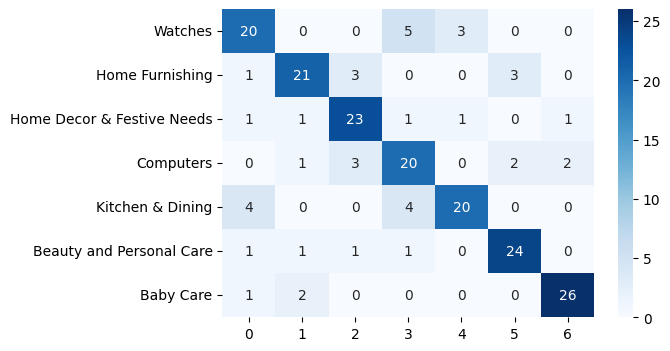

In [37]:
df_cm = pd.DataFrame(conf_mat, index=[categ for categ in categories_liste],
                     columns=[i for i in "0123456"])
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## <font size="+2" color="#903b3f"><b>2.3. Approche ImageDatagenerator avec data augmentation</b></font><br><a name="imgDataGen"></a>


CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow (noté désormais comme "deprecated", incite à utiiser l'approche suivante)

In [38]:
# Pour mélanger les images, éviter le classement par classe
df_reference = df_reference.sample(frac=1, random_state=42)\
                                    .reset_index(drop=True)

In [39]:
batch_size = 32


def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image_loc', y_col='Categ_N0',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=seed,
                                subset=data_type
                                )
    return data_flow

In [40]:
datagen_train = ImageDataGenerator(
    #  featurewise_center=True,
    #  featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(df_reference, datagen_train, data_type='training')
val_flow = data_flow_fct(df_reference, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(df_test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 591 validated image filenames belonging to 7 classes.
Found 196 validated image filenames belonging to 7 classes.
Found 263 validated image filenames belonging to 7 classes.


In [41]:
# Création du modèle
with tensorflow.device('/gpu:0'):
    model2 = create_model_VGG16_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [42]:
print("Num GPUs Available: ",
      len(tensorflow.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [43]:
with tensorflow.device('/gpu:0'):
    history2 = model2.fit(train_flow,
                          validation_data=val_flow,
                          batch_size=batch_size, epochs=50,
                          callbacks=callbacks_list,
                          verbose=1)

Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 3.6863 - accuracy: 0.5025

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.92449, saving model to ./model2_best_weights.h5
19/19 [==============================] - 52s 3s/step - loss: 3.6863 - accuracy: 0.5025 - val_loss: 0.9245 - val_accuracy: 0.7857
Epoch 2/50
19/19 [==============================] - ETA: 0s - loss: 1.4284 - accuracy: 0.6988
Epoch 2: val_loss improved from 0.92449 to 0.86143, saving model to ./model2_best_weights.h5
19/19 [==============================] - 37s 2s/step - loss: 1.4284 - accuracy: 0.6988 - val_loss: 0.8614 - val_accuracy: 0.7755
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 0.9023 - accuracy: 0.7800
Epoch 3: val_loss did not improve from 0.86143
19/19 [==============================] - 34s 2s/step - loss: 0.9023 - accuracy: 0.7800 - val_loss: 0.8851 - val_accuracy: 0.7806
Epoch 4/50
19/19 [==============================] - ETA: 0s - loss: 0.6728 - accuracy: 0.8054
Epoch 4: val_loss improved from 0.86143 to 0.75807, saving model to ./model2_best_weights.h5
19/19 [=

In [44]:
# Score du dernier epoch
loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()

loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

19/19 [==============================] - 25s 1s/step - loss: 0.0430 - accuracy: 0.9848
Training Accuracy   : 0.9848

7/7 [==============================] - 9s 1s/step - loss: 0.7810 - accuracy: 0.8571
Validation Accuracy :  0.8571


In [45]:
# Score de l'epoch optimal
model2.load_weights(model2_save_path)

loss_vali_model2, accuracy_vali_model2 = model2.evaluate(val_flow,
                                                         verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_vali_model2))

loss_test_model2, accuracy_test_model2 = model2.evaluate(test_flow,
                                                         verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_model2))

Validation Accuracy :  0.8520
Test Accuracy       :  0.9392


In [46]:
# Information à garder pour la comparaison des performances

approach.append("ImgDataGenerator")
loss_vali_opt.append(loss_vali_model2)
accuracy_vali_opt.append(accuracy_vali_model2)
loss_test_opt.append(loss_test_model2)
accuracy_test_opt.append(accuracy_test_model2)

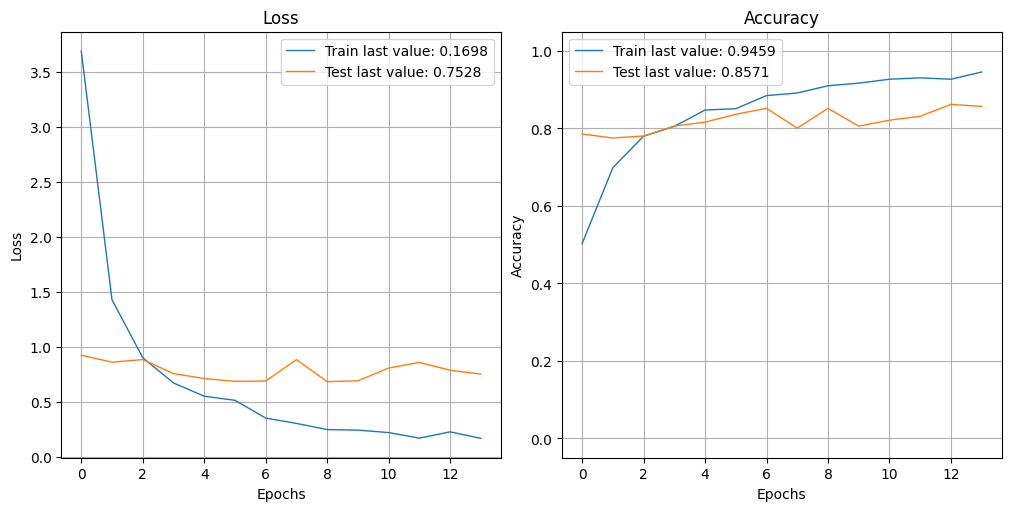

In [47]:
show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

val_flow_num = np.argmax(val_flow, axis=1)
val_flow_pred = np.argmax(model1.predict(val_flow), axis=1)

print(val_flow_num)
print()
print(val_flow_pred)

conf_mat = metrics.confusion_matrix(val_flow_num, val_flow_pred)
print(conf_mat)

val_flow_pred_transform = conf_mat_transform(val_flow_num, val_flow_pred)
conf_mat = metrics.confusion_matrix(val_flow_num, val_flow_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(val_flow_num, val_flow_pred_transform))

df_cm = pd.DataFrame(conf_mat, index = [categ for categ in categories_liste],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## <font size="+2" color="#903b3f"><b>2.4. Approche nouvelle par Dataset sans data augmentation</b></font><br><a name="new_approach"></a>

CF https://www.tensorflow.org/tutorials/load_data/images

### <font size="+2" color="#c0553d"><b>2.4.1. Modification structure dossier images<b></font><br><a name="modif_structure_dossier"></a>

*# Création des sous dossiers par catégorie
col = "Categ_N0"

for value in df_reference[col]:
    Path(f'../p6_source/img_subfolder/train_val/{value}')\
          .mkdir(parents=True, exist_ok=True)

for value in df_test[col]:
    Path(f'../p6_source/img_subfolder/test_img/{value}')\
          .mkdir(parents=True, exist_ok=True)

In [48]:
train_val_directory = "/content/drive/MyDrive/Projet6_NLP/P6_travail/p6_source/img_subfolder/train_val/"

df_reference.apply(lambda row: shutil.copyfile(row['image_loc'],
                                               (train_val_directory +
                                                row['Categ_N0']+ '//' +
                                                row['image'])), axis=1)

In [49]:
test_directory = "/content/drive/MyDrive/Projet6_NLP/P6_travail/p6_source/img_subfolder/test_img/"

df_test.apply(lambda row: shutil.copyfile(row['image_loc'], (test_directory +
                                                             row['Categ_N0']+
                                                             '//'
                                                              + row['image'])),
               axis=1)

### <font size="+2" color="#c0553d"><b>2.4.2. Application approche par Dataset<b></font><br><a name="applic_approche"></a>

In [50]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tensorflow.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=32, image_size=(224, 224),
                    shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset


In [51]:
dataset_train = dataset_fct(train_val_directory, validation_split=0.25,
                            data_type='training')
dataset_val = dataset_fct(train_val_directory, validation_split=0.25,
                          data_type='validation')
dataset_test = dataset_fct(test_directory, validation_split=0, data_type=None)

Found 787 files belonging to 7 classes.
Using 591 files for training.
Found 787 files belonging to 7 classes.
Using 196 files for validation.
Found 263 files belonging to 7 classes.


In [52]:
# Création du modèle
with tensorflow.device('/gpu:0'):
    model3 = create_model_VGG16_fct()

# Création du callback
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [53]:
print("Num GPUs Available: ",
      len(tensorflow.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [54]:
with tensorflow.device('/gpu:0'):
    history3 = model3.fit(dataset_train,
                          validation_data=dataset_val,
                          batch_size=batch_size, epochs=50,
                          callbacks=callbacks_list,
                          verbose=1)

Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 6.6507 - accuracy: 0.4569
Epoch 1: val_loss improved from inf to 1.27594, saving model to ./model3_best_weights.h5
19/19 [==============================] - 130s 5s/step - loss: 6.6507 - accuracy: 0.4569 - val_loss: 1.2759 - val_accuracy: 0.8112
Epoch 2/50
19/19 [==============================] - ETA: 0s - loss: 2.0413 - accuracy: 0.7394
Epoch 2: val_loss improved from 1.27594 to 1.16476, saving model to ./model3_best_weights.h5
19/19 [==============================] - 11s 399ms/step - loss: 2.0413 - accuracy: 0.7394 - val_loss: 1.1648 - val_accuracy: 0.8367
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 1.2536 - accuracy: 0.7766
Epoch 3: val_loss improved from 1.16476 to 1.04104, saving model to ./model3_best_weights.h5
19/19 [==============================] - 11s 482ms/step - loss: 1.2536 - accuracy: 0.7766 - val_loss: 1.0410 - val_accuracy: 0.8214
Epoch 4/50
19/19 [==============================]

In [55]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

19/19 [==============================] - 6s 218ms/step - loss: 9.6075e-04 - accuracy: 1.0000
Training Accuracy   : 1.0000

7/7 [==============================] - 2s 114ms/step - loss: 1.1696 - accuracy: 0.8469
Validation Accuracy :  0.8469


In [56]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss_vali_model3, accuracy_vali_model3 = model3.evaluate(dataset_val,
                                                         verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_vali_model3))

loss_test_model3, accuracy_test_model3 = model3.evaluate(dataset_test,
                                                         verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_model3))

Validation Accuracy :  0.8622
Test Accuracy       :  0.9734


In [57]:
# Information à garder pour la comparaison des performances

approach.append("New_approach_without_dataAugm")
loss_vali_opt.append(loss_vali_model3)
accuracy_vali_opt.append(accuracy_vali_model3)
loss_test_opt.append(loss_test_model3)
accuracy_test_opt.append(accuracy_test_model3)

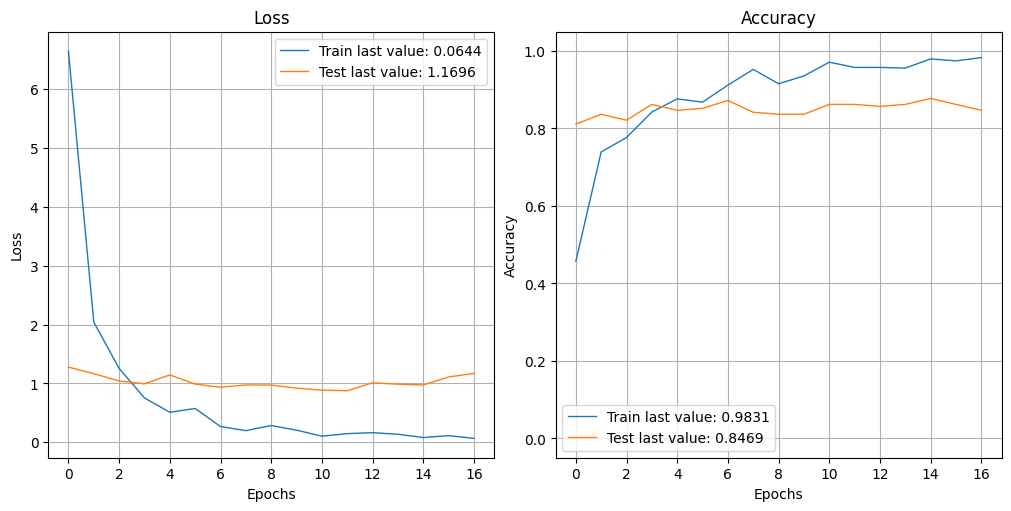

In [58]:
show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

## <font size="+2" color="#903b3f"><b>2.5. Approche nouvelle par Dataset avec data augmentation intégrée au modèle</b></font><br><a name="new_approach_dataAug"></a>

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [59]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tensorflow.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size,
                    image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [60]:
dataset_train = dataset_fct(train_val_directory, validation_split=0.25,
                            data_type='training')
dataset_val = dataset_fct(train_val_directory, validation_split=0.25,
                          data_type='validation')
dataset_test = dataset_fct(test_directory, validation_split=0, data_type=None)

Found 787 files belonging to 7 classes.
Using 591 files for training.
Found 787 files belonging to 7 classes.
Using 196 files for validation.
Found 263 files belonging to 7 classes.


def resize_and_rescale(image, label):
    image = tensorflow.cast(image, tensorflow.float32)
    image = tensorflow.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [61]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet",
                       input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam',
                  metrics=["accuracy"])

    print(model.summary())
    
    return model

In [62]:
# Création du modèle
with tensorflow.device('/gpu:0'):
    model4 = create_model_fct2()

# Création du callback
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                      

In [63]:
print("Num GPUs Available: ", len(tensorflow.config
                                  .list_physical_devices('GPU')))

Num GPUs Available:  1


In [64]:
with tensorflow.device('/gpu:0'): 
    history4 = model4.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50,
                    callbacks=callbacks_list, verbose=1)

Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 1.8577 - accuracy: 0.2758
Epoch 1: val_loss improved from inf to 1.39122, saving model to ./model4_best_weights.h5
19/19 [==============================] - 14s 521ms/step - loss: 1.8577 - accuracy: 0.2758 - val_loss: 1.3912 - val_accuracy: 0.6531
Epoch 2/50
19/19 [==============================] - ETA: 0s - loss: 1.3620 - accuracy: 0.5618
Epoch 2: val_loss improved from 1.39122 to 1.05283, saving model to ./model4_best_weights.h5
19/19 [==============================] - 8s 348ms/step - loss: 1.3620 - accuracy: 0.5618 - val_loss: 1.0528 - val_accuracy: 0.7500
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 1.1343 - accuracy: 0.6582
Epoch 3: val_loss improved from 1.05283 to 0.90582, saving model to ./model4_best_weights.h5
19/19 [==============================] - 11s 462ms/step - loss: 1.1343 - accuracy: 0.6582 - val_loss: 0.9058 - val_accuracy: 0.7551
Epoch 4/50
19/19 [==============================

In [65]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val,verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

19/19 [==============================] - 8s 240ms/step - loss: 0.2083 - accuracy: 0.9306
Training Accuracy   : 0.9306

7/7 [==============================] - 2s 111ms/step - loss: 0.5481 - accuracy: 0.8418
Validation Accuracy :  0.8418


In [66]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss_vali_model4, accuracy_vali_model4 = model4.evaluate(dataset_val,
                                                         verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_vali_model4))

loss_test_model4, accuracy_test_model4 = model4.evaluate(dataset_test,
                                                         verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_model4))

Validation Accuracy :  0.8776
Test Accuracy       :  0.9087


In [67]:
# Information à garder pour la comparaison des performances

approach.append("New_approach_with_dataAugm")
loss_vali_opt.append(loss_vali_model4)
accuracy_vali_opt.append(accuracy_vali_model4)
loss_test_opt.append(loss_test_model4)
accuracy_test_opt.append(accuracy_test_model4)

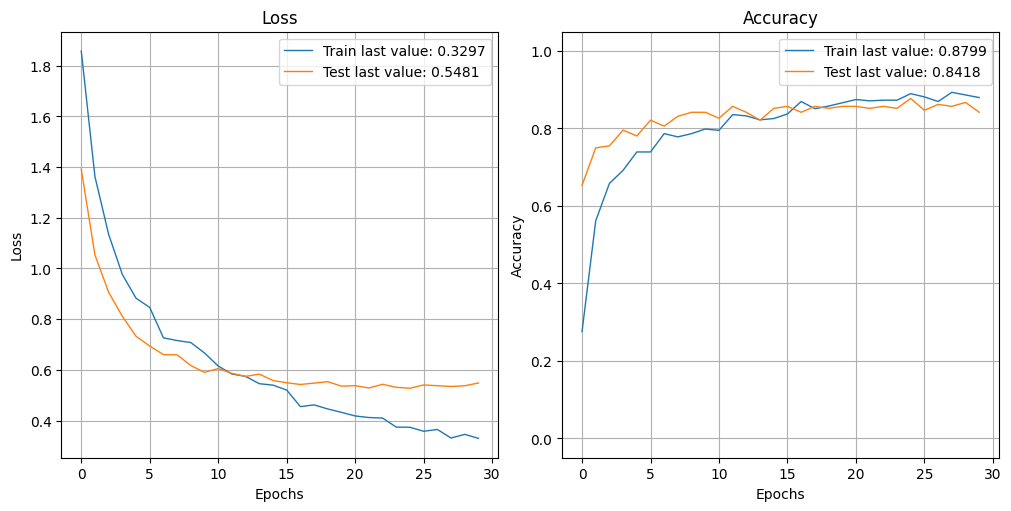

In [68]:
show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

# <font size="+3" color="#5c2835"><b>3. Comparaison des performances</b></font><br><a name="comparaison_perf"></a>

In [69]:
df_compar_perf = pd.DataFrame({
        "Approche": approach,
        "Loss_validation": loss_vali_opt,
        "Accuracy_validation": accuracy_vali_opt,
        "Loss_test": loss_test_opt,
        "Accuracy_test": accuracy_test_opt})

In [70]:
df_compar_perf=df_compar_perf.sort_values(by="Accuracy_test")
df_compar_perf

,Approche,Loss_validation,Accuracy_validation,Loss_test,Accuracy_test
0,Prep_Init,1.426272,0.781726,0.894151,0.828897
3,New_approach_with_dataAugm,0.527336,0.877551,0.270684,0.908745
1,ImgDataGenerator,0.694155,0.852041,0.382887,0.939164
2,New_approach_without_dataAugm,0.874392,0.862245,0.103621,0.973384


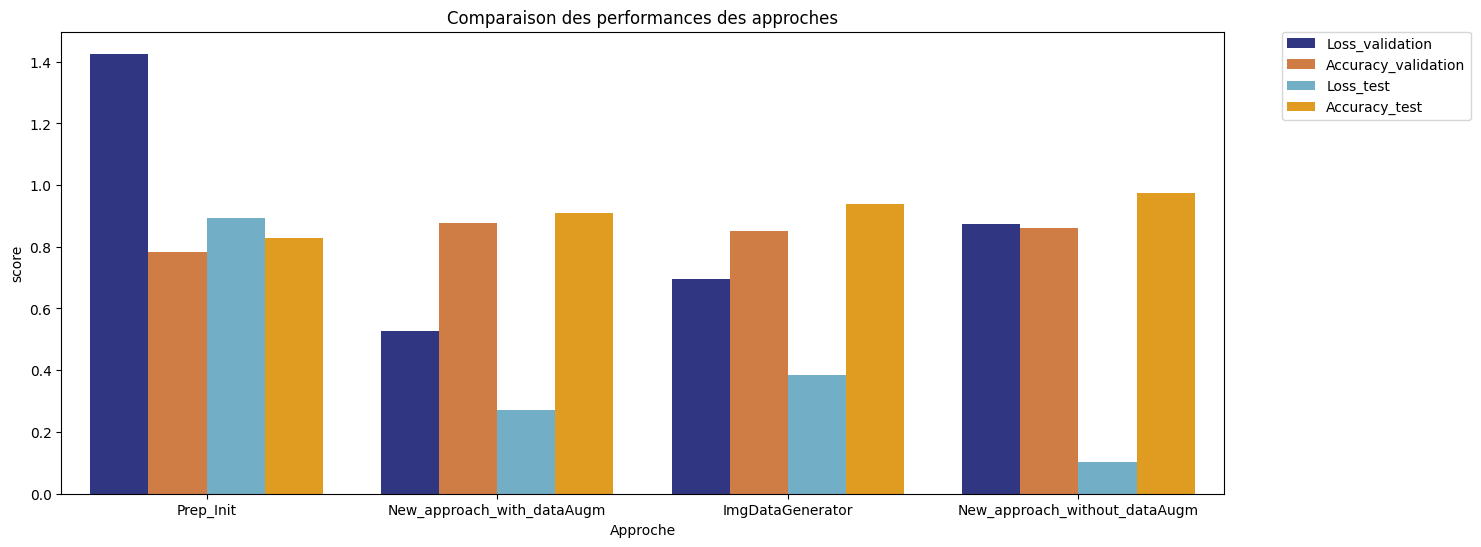

In [71]:
# Comparaison des algorithmes
comparaison_melt = pd.melt(df_compar_perf, id_vars=["Approche"],
                           value_name="score", value_vars=["Loss_validation",
                                                           "Accuracy_validation",
                                                           "Loss_test",
                                                           "Accuracy_test"])

# Visualisation
plt.figure(figsize=(15, 6))
sns.barplot(x=comparaison_melt["Approche"],
            y=comparaison_melt["score"], hue=comparaison_melt["variable"],
            palette=["#222b8f", "#e6792e", "#64b5d5", "#ffa600"])
plt.title("Comparaison des performances des approches", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)
plt.show()

<a id='END'></a>

---
---

# <span style='background:#5c2835'><span style='color:white'>**END** </span></span>
